The objective of this project is to replicate Richard S. Sutton's article on Learning to Predict by Methods of Temporal Differences and implement Random Walk using temporal differences instead of supervised learning.

For further details and analysis, please review Random_walk.pdf.

Steps to run the uploaded Jupyter Notebook, random_walk.ipynb, are shown below. This will create and run the random walk algorithm using temporal differences and corresponding plots:

1) Run cell 1 to import all the necessary libraries and create the class to perform the Random Walk algorithm

2) Run cell 2 to run experiment 1 which tests updating the weights every 10 sequences

3) Run cell 3 to create a plot to show the error for each lambda value using a constant alpha

4) Run cell 4 to run experiment 2 which updates the weights after each sequence

5) Run cell 5 to create a plot to show the error for each alpha value for each lambda

6) Run cell 6 to create a plot to show the error for each lambda value using best alpha


In [1]:
#setup
import numpy as np
import matplotlib.pyplot as plt

#Perform random walk
class random_walk():
    #initialize states and weights
    def __init__(self):        
        self.states = {0:0,1:np.array([1,0,0,0,0]).T,2:np.array([0,1,0,0,0]).T,3:np.array([0,0,1,0,0]).T,4:np.array([0,0,0,1,0]).T,5:np.array([0,0,0,0,1]).T,6:1}
        self.w = np.array([0.,0.,0.,0.,0.]).T
        self.gamma = 0.7

    #check for terminal state
    def end(self,s):
        #if state is G
        if s == 6:
            #reward of +1 and ends
            z = 1
            return True,z
        #if state is A
        elif s == 0:
            #reward of -1 and ends
            z = -1
            return True,z
        else:
            #no reward and does not end
            return False,0

    #take steps
    def play(self):
        #start in middle at D
        s = 3
        game_over = False
        seq = [3]

        #continue until game over
        while not game_over:
            #randomly choose to go left or right
            a = np.random.choice([s-1,s+1],1)[0]
            
            #check if game is over and reward
            game_over,z = random_walk.end(self,a)
            #once game is over, return sequence
            if game_over:
                return seq,z

            #update sequence with each step
            seq.append(a)
            s = a

In [3]:
#Experiment 1 - update weights every 10 sequences
def exp_1(rw,alpha,lmbda,sets):
    actual = [1/6,1/3,1/2,2/3,5/6]

    rmse = 0

    np.random.seed(10)

    #initialize weights at 0
    w_c = [0.] * len(rw.w)
    t_sets = []
    #generate specified value of sets using random walk
    for t in range(sets):
        seqs = []
        #each set should have 10 sequences of steps
        for i in range(10):
            seq,z = rw.play()
            seqs.append((seq,z))
        t_sets.append(seqs)
    #for each set generated of 10 sequences
    for t_set in t_sets:
        diff = 3
        #continue while the update is still bigger than threshold of 0.02
        while diff > 0.02:
            old_w = w_c.copy()
            #for each sequence
            for set in t_set:
                seq,z = set

                for t in range(1,len(seq)):
                    #calculate the change in weights
                    pt = np.dot(rw.w,rw.states[seq[t]])

                    if t==len(seq)-1:
                        reward = z
                        pt_next = 0
                    else:
                        reward = 0
                        pt_next = np.dot(rw.w,rw.states[seq[t+1]])

                    lmbda_pwr = [np.power(lmbda,t-k)*rw.states[seq[k]] for k in range(1,t+1)]
                    #sum up deltas
                    w_c += (alpha*(reward +pt_next-pt)*np.sum(lmbda_pwr,axis=0))/(10*len(seq))
            #find average change
            diff = np.mean([abs(old_w[i] - w_c[i]) for i in range(len(w_c))])
        #update weights
        rw.w += w_c
        rmse += np.sqrt(np.mean(np.power(rw.w-actual,2)))
        
        rw.w = np.array([0.,0.,0.,0.,0.]).T
    #get rmse
    rmse /= sets
    return rmse

0.5416800386891005

Text(0, 0.5, 'RMS error')

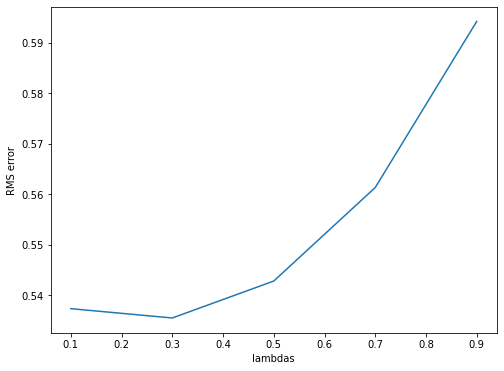

In [4]:
#Plot error for each lambda value using a constant alpha
alpha = 0.1
lambdas = [0.1,0.3,0.5,0.7,0.9] 
sets = 100

plt.figure(figsize=[8,6])
errors = []
for lmb in lambdas:
    rmse = 0
    rw = random_walk()
    rmse = exp_1(rw,alpha,lmb,sets)
    errors.append(rmse)
plt.plot(lambdas,errors)

plt.xlabel("lambdas")
plt.ylabel("RMS error")


In [5]:
#Experiment 2 - weights updated after each sequence
def exp_2(rw,alpha,lmbda):
    #initial weights set to 0.5
    rw.w = np.array([0.5,0.5,0.5,0.5,0.5]).T

    seqs = []
    #generate 10 sequences
    for i in range(10):
        seq,z = rw.play()
        seqs.append((seq,z))

    #for each sequence
    for set in seqs:
        seq,z = set
        w_c = [0.] * len(rw.w)

        for t in range(1,len(seq)):
            #calculate change in weights
            pt = np.dot(rw.w,rw.states[seq[t]])
            if t==len(seq)-1:
                reward = z
                pt_next = 0
            else:
                reward = 0
                pt_next = np.dot(rw.w,rw.states[seq[t+1]])

            if lmbda == 0:
                lmbda_pwr = rw.states[seq[1]]
            else:
                lmbda_pwr = np.sum([np.power(lmbda,t-k)*rw.states[seq[k]] for k in range(1,t+1)],axis=0)
            w_c += alpha*(reward + rw.gamma*pt_next-pt)*rw.gamma*lmbda_pwr
        #update weights after each sequence
        rw.w += w_c/len(seq)

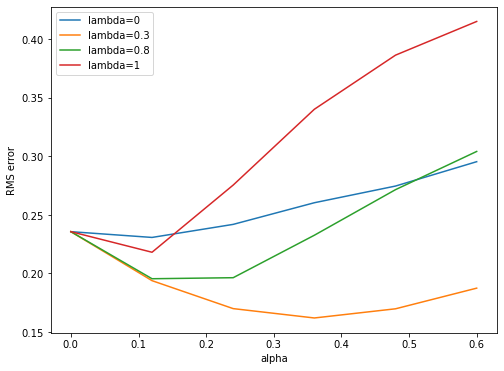

In [6]:
#Plot RMSE for each alpha value for each lambda
alphas = np.linspace(0,0.6,6)
lambdas = [0,0.3,0.8,1] 
actual = [1/6,1/3,1/2,2/3,5/6]
sets = 100

plt.figure(figsize=[8,6])
for lmb in lambdas:
    errors = []
    for a in alphas:
        rmse = 0
        rw = random_walk()
        for i in range(0,sets):
            exp_2(rw,a,lmb)
            rmse += np.sqrt(np.mean(np.power(rw.w-actual,2)))
        rmse /= sets
        errors.append(rmse)
    plt.plot(alphas,errors,label="lambda={}".format(lmb))

plt.xlabel("alpha")
plt.ylabel("RMS error")
plt.legend()


Text(0, 0.5, 'RMS error')

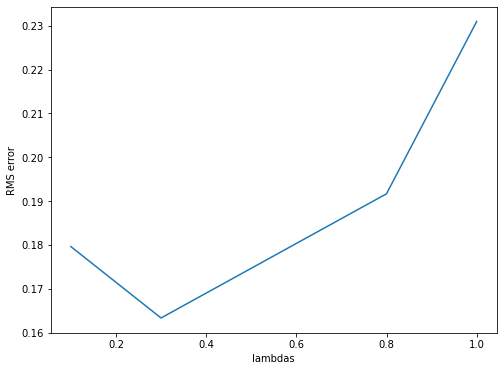

In [7]:
#Plot RMSE for each lambda value using best alpha
alphas = [0.2,0.35,0.15,0.15]
lambdas = [0.1,0.3,0.8,1] 
actual = [1/6,1/3,1/2,2/3,5/6]
sets = 100

plt.figure(figsize=[8,6])
errors = []
for l in range(len(lambdas)):
    a = alphas[l]
    rmse = 0
    for i in range(0,sets):
        rw = random_walk()
        exp_2(rw,a,lambdas[l])
        rmse += np.sqrt(np.mean(np.power(rw.w-actual,2)))
    rmse /= sets
    errors.append(rmse)
plt.plot(lambdas,errors)

plt.xlabel("lambdas")
plt.ylabel("RMS error")
